In [1]:
using Clapeyron
using Plots
using CSV
using DataFrames
using LaTeXStrings
using Measures

### MEA + H20 + CO2 (with association sites) 

In [2]:
model_assoc = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Carbon Dioxide",["CO2"=>1])];
        userlocations = 
        (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 44.01],
        epsilon = [284.78 348.39 528.21 339.89 134.58;
                   348.39 473.39 423.17 423.63 276.45;
                   528.21 423.17 407.22 358.02 312.3;
                   339.89 423.63 358.02 266.68 226.38;
                   134.58 276.45 312.3 226.38 207.89],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.05],
        lambda_a = [6, 6, 6, 6, 5.055],
        lambda_r = [10.354 14.063 52.305 13.085 50.06;
                    14.063 19.871 21.230 100.00 22.873;
                    52.305 21.230 22.699 19.619 24.474;
                    13.085 100.00 19.619 17.020 21.116;
                    50.06  22.873 24.474 21.116 26.408],
        vst = [1, 1, 2, 1, 2],
        S = [0.79675, 0.22932, 0.58538, 1, 0.84680],
        n_H=[2, 0, 1, 2, 0],
        n_e=[1, 0, 2, 2, 0],
        n_a1=[0, 0, 0, 0, 1],
        n_a2=[0, 0, 0, 0, 1],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.6,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("CO2","a1"),("NH2","e")) => 3313,
                              (("CO2","a1"),("H2O","e")) => 1398.1,
                              (("CO2","a2"),("NH2","e")) => 4943.6]),
        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                        (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                        (("NH2","H"),("H2O","e")) => 22.450e-30,
                        (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                        (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                        (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                        (("H2O","H"),("NH2","e")) => 459.18e-30,
                        (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                        (("H2O","H"),("H2O","e")) => 101.69e-30,
                        (("CO2","a1"),("NH2","e")) => 3280.3e-30,
                        (("CO2","a1"),("H2O","e")) => 91.419e-30,
                        (("CO2","a2"),("NH2","e")) => 142.64e-30])));

In [3]:
wt_MEA = 0.3
wt_H2O = 1-wt_MEA

mw_MEA = 61.08
mw_H2O = 18.01528

x_MEA = (wt_MEA/mw_MEA)*(1/((wt_MEA/mw_MEA)+(wt_H2O/mw_H2O)))
x_H2O = 1-x_MEA
solvrat = x_H2O/x_MEA

7.911062165006595

In [4]:
load = LinRange(0, 1.2, 100) #these are the ratio of CO2 mols to MEA mols in solution

N = length(load)

# intialise new composition vectors
x_MEA = zeros(N, 1)
x_H2O = zeros(N, 1)
x_CO2 = zeros(N, 1)
z = zeros(N, 3)

# calculate the new liquid compositions at these loadings
x_MEA = 1 ./ (1 .+ load .+ solvrat)
x_CO2 = x_MEA .* load
x_H2O = 1 .- x_MEA .- x_CO2
z = hcat(x_MEA, x_H2O, x_CO2);

In [5]:
T = [298.15, 313.15, 333.15, 353.15, 373.15]

pvap = zeros(N, 5)
y = zeros(N, 3, 5)
partial = zeros(N, 5)

for j in 1:5      
    for i in 1:N
        x_bub = z[i, :]
        calc = bubble_pressure(model_assoc, T[j], x_bub)
        pvap[i, j] = calc[1]
        y[i, 1, j] = calc[4][1]
        y[i, 2, j] = calc[4][2]
        y[i, 3, j] = calc[4][3]
    end
end

partialT1_assoc = pvap[2:100, 1] .* y[2:100, 3, 1]
partialT2_assoc = pvap[2:100, 2] .* y[2:100, 3, 2]
partialT3_assoc = pvap[2:100, 3] .* y[2:100, 3, 3]
partialT4_assoc = pvap[2:100, 4] .* y[2:100, 3, 4]
partialT5_assoc = pvap[2:100, 5] .* y[2:100, 3, 5]

loadfil = load[2:100];


### Experimental Data 

In [6]:
exp_298 = CSV.read("MEA_H2O_CO2_loading_298.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_313 = CSV.read("MEA_H2O_CO2_loading_313.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_333 = CSV.read("MEA_H2O_CO2_loading_333.15.csv",
               header=[1, 2, 3],
               DataFrame);

exp_353 = CSV.read("MEA_H2O_CO2_loading_353.15.csv",
               header=[1, 2, 3],
               DataFrame);
    
exp_373 = CSV.read("MEA_H2O_CO2_loading_373.15.csv",
               header=[1, 2, 3],
               DataFrame);

LoadError: ArgumentError: "MEA_H2O_CO2_loading_298.15.csv" is not a valid file or doesn't exist

### MEA + H2O + CO2 (without H2O + CO2 interaction)

In [7]:
model_no_assoc = SAFTgammaMie([("MEA",["NH2"=>1, "CH2"=>1, "CH2OH"=>1]),("Water",["H2O"=>1]),("Carbon Dioxide",["CO2"=>1])];
        userlocations = 
        (Mw = [16.02285, 14.02658, 31.03392, 18.01528, 44.01],
        epsilon = [284.78 348.39 528.21 339.89 134.58;
                   348.39 473.39 423.17 423.63 276.45;
                   528.21 423.17 407.22 358.02 312.3;
                   339.89 423.63 358.02 266.68 226.38;
                   134.58 276.45 312.3 226.38 207.89],
        sigma = [3.2477, 4.8801, 3.4054, 3.0063, 3.05],
        lambda_a = [6, 6, 6, 6, 5.055],
        lambda_r = [10.354 14.063 52.305 13.085 50.06;
                    14.063 19.871 21.230 100.00 22.873;
                    52.305 21.230 22.699 19.619 24.474;
                    13.085 100.00 19.619 17.020 21.116;
                    50.06  22.873 24.474 21.116 26.408],
        vst = [1, 1, 2, 1, 2],
        S = [0.79675, 0.22932, 0.58538, 1, 0.84680],
        n_H=[2, 0, 1, 2, 0],
        n_e=[1, 0, 2, 2, 0],
        n_a1=[0, 0, 0, 0, 1],
        n_a2=[0, 0, 0, 0, 1],
        epsilon_assoc = Dict([(("NH2","H"),("NH2","e")) => 1070.80,
                              (("NH2","H"),("CH2OH","e")) => 629.88,
                              (("NH2","H"),("H2O","e")) => 1364.40,
                              (("CH2OH","H"),("NH2","e")) => 2403.78,
                              (("CH2OH","H"),("CH2OH","e")) => 2097.90,
                              (("CH2OH","H"),("H2O","e")) => 600.00,
                              (("H2O","H"),("NH2","e")) => 1877.50,
                              (("H2O","H"),("CH2OH","e")) => 2000.6,
                              (("H2O","H"),("H2O","e")) => 1985.40,
                              (("CO2","a1"),("NH2","e")) => 3313,
                              #(("CO2","a1"),("H2O","e")) => 1398.1,
                              (("CO2","a2"),("NH2","e")) => 4943.6]),
        bondvol = Dict([(("NH2","H"),("NH2","e")) => 95.225e-30,
                        (("NH2","H"),("CH2OH","e")) => 346.08e-30,
                        (("NH2","H"),("H2O","e")) => 22.450e-30,
                        (("CH2OH","H"),("NH2","e")) => 26.192e-30,
                        (("CH2OH","H"),("CH2OH","e")) => 62.309e-30,
                        (("CH2OH","H"),("H2O","e")) => 490.19e-30,
                        (("H2O","H"),("NH2","e")) => 459.18e-30,
                        (("H2O","H"),("CH2OH","e")) => 130.02e-30,
                        (("H2O","H"),("H2O","e")) => 101.69e-30,
                        (("CO2","a1"),("NH2","e")) => 3280.3e-30,
                        #(("CO2","a1"),("H2O","e")) => 91.419e-30,
                        (("CO2","a2"),("NH2","e")) => 142.64e-30])));

In [8]:
T = [298.15, 313.15, 333.15, 353.15, 373.15]

pvap = zeros(N, length(T))
y = zeros(N, 3, length(T))
partial = zeros(N, length(T))

for j in 1:length(T)     
    for i in 1:N
        x_bub = z[i, :]
        # change the bubble pressure method
        calc = bubble_pressure(model_no_assoc, T[j], x_bub)
        pvap[i, j] = calc[1]
        y[i, 1, j] = calc[4][1]
        y[i, 2, j] = calc[4][2]
        y[i, 3, j] = calc[4][3]
    end
end

partialT1_no_assoc = pvap[2:100, 1] .* y[2:100, 3, 1]
partialT2_no_assoc = pvap[2:100, 2] .* y[2:100, 3, 2]
partialT3_no_assoc = pvap[2:100, 3] .* y[2:100, 3, 3]
partialT4_no_assoc = pvap[2:100, 4] .* y[2:100, 3, 4]
partialT5_no_assoc = pvap[2:100, 5] .* y[2:100, 3, 5]

loadfil = load[2:100];


LoadError: LinearAlgebra.SingularException(8)

##### T = 373.15K

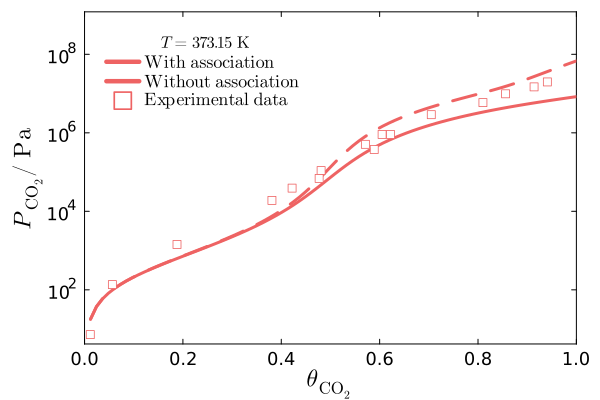

In [ ]:
gr()

plt1 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T = 373.15 \ \mathrm{K}",
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt1, loadfil, partialT5_assoc, 
      color = "indianred2", 
      line = (:path, 3), 
      label = L"\mathrm{With \ association}")

plot!(plt1, loadfil, partialT5_no_assoc, 
      color = "indianred2", 
      seriestype = :path,
      linestyle = :dash,
      lw =3, 
      label = L"\mathrm{Without \ association}")

plot!(plt1, exp_373[:, 2], exp_373[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "indianred2",
            marker = :square,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = L"\mathrm{Experimental \ data}")


xlabel!(plt1, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt1, L"P_{\mathrm{CO_2}} / \ \mathrm{Pa}")
#savefig(plt1, "Compara_Loading_373.pdf")

# df = DataFrame(
#     loadfil = loadfil,  
#     partialT5_assoc = partialT5_assoc,  
#     partialT5_no_assoc = partialT5_no_assoc  
# )
# CSV.write("comparison_373.csv", df)

#### T = 353.15K

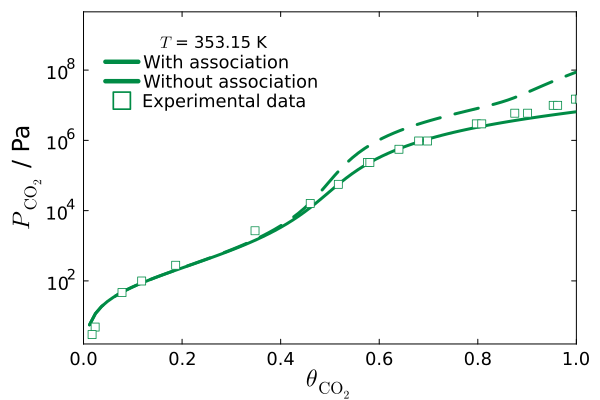

In [ ]:
plt2 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T "*" = 353.15 K",
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt2, loadfil, partialT4_assoc, 
      color = "springgreen4", 
      line = (:path, 3), 
      label = "With association")

plot!(plt2, loadfil, partialT4_no_assoc, 
      color = "springgreen4", 
      line = (:dash, 3), 
      label = "Without association")

plot!(plt2, exp_353[:, 2], exp_353[:, 1],
      seriestype = :scatter, 
      color = "white", 
      markerstrokecolor = "springgreen4",
      marker = :square,
      markerstrokewidth = 1,
      line = (:scatter, 3), 
      label = "Experimental data")

xlabel!(plt2, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt2, L"P_{\mathrm{CO_2}} / \ \mathrm{Pa}")

#savefig(plt2, "Compara_Loading_353")

# df = DataFrame(
#     loadfil = loadfil,  
#     partialT5_assoc = partialT4_assoc,  
#     partialT5_no_assoc = partialT4_no_assoc  
# )
# CSV.write("comparison_353.csv", df)

#### T = 333.15K

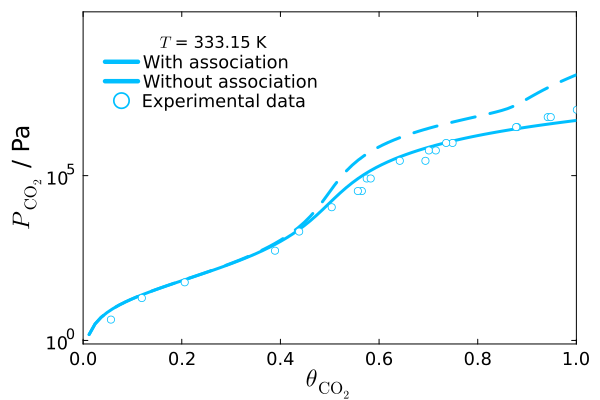

In [ ]:
plt3 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T "*" = 333.15 K",
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt3, loadfil, partialT3_assoc, 
      color = "deepskyblue1", 
      line = (:path, 3), 
      label = "With association")

plot!(plt3, loadfil, partialT3_no_assoc, 
      color = "deepskyblue1", 
      line = (:dash, 3), 
      label = "Without association")

plot!(plt3, exp_333[:, 2], exp_333[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "deepskyblue1",
            marker = :circsle,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "Experimental data")

xlabel!(plt3, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt3, L"P_{\mathrm{CO_2}} / \ \mathrm{Pa}")

# savefig(plt3, "Compara_Loading_333")

# df = DataFrame(
#     loadfil = loadfil,  
#     partialT5_assoc = partialT3_assoc,  
#     partialT5_no_assoc = partialT3_no_assoc  
# )
# CSV.write("comparison_333.csv", df)



#### T = 313.15K

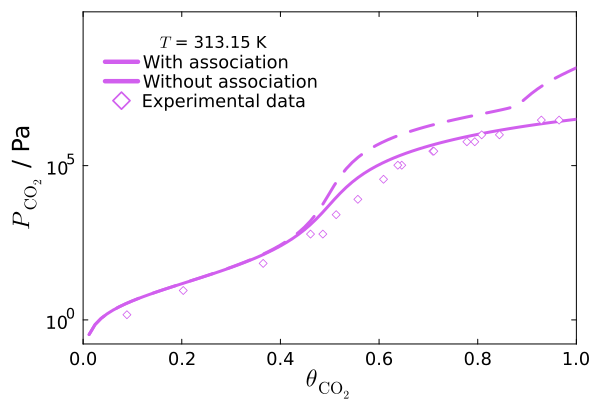

In [ ]:
plt4 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T "*" = 313.15 K",
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt4, loadfil, partialT2_assoc, 
      color = "mediumorchid2", 
      line = (:path, 3), 
      label = "With association") 

plot!(plt4, loadfil, partialT2_no_assoc, 
      color = "mediumorchid2", 
      line = (:dash, 3), 
      label = "Without association")

plot!(plt4, exp_313[:, 2], exp_313[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "mediumorchid2",
            marker = :diamond,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "Experimental data")

xlabel!(plt4, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt4, L"P_{\mathrm{CO_2}} / \ \mathrm{Pa}")

# savefig(plt4, "Compara_Loading_313")

# df = DataFrame(
#     loadfil = loadfil,  
#     partialT5_assoc = partialT2_assoc,  
#     partialT5_no_assoc = partialT2_no_assoc  
# )
# CSV.write("comparison_313.csv", df)

#### T = 298.15K

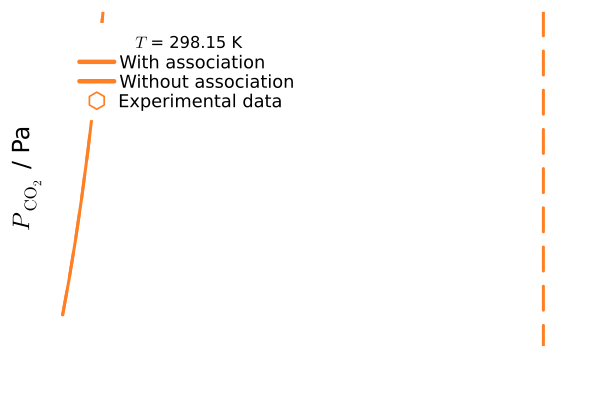

┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194
┌ Warning: No strict ticks found
└ @ PlotUtils C:\Users\fjm21\.julia\packages\PlotUtils\8mrSm\src\ticks.jl:194


In [ ]:
plt5 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T "*" = 298.15 K",
      xtickfont = font(12),
      ytickfont = font(12),
      yaxis = :log,
      xlims = (0, 1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt5, loadfil, partialT1_assoc, 
      color = "chocolate1", 
      line = (:path, 3), 
      label = "With association")

plot!(plt5, loadfil, partialT1_no_assoc, 
      color = "chocolate1", 
      line = (:dash, 3), 
      label = "Without association")

plot!(plt5, exp_298[:, 2], exp_298[:, 1],
            seriestype = :scatter, 
            color = "white", 
            markerstrokecolor = "chocolate1",
            marker = :hexagon,
            markerstrokewidth = 1,
            line = (:scatter, 3), 
            label = "Experimental data")


xlabel!(plt5, "θ"*L"\mathrm{_{CO_2}}")
ylabel!(plt5, L"P_{\mathrm{CO_2}}"*" / Pa")

#### Speciation 

In [9]:
T = [293.15, 313.15]

pvap = zeros(N, length(T))
y = zeros(N, 3, length(T))
partial = zeros(N, length(T))
xNHCOO = zeros(N, length(T))
xHCO3 = zeros(N, length(T))

for j in 1:length(T)     
    for i in 1:N
        x_bub = z[i, :]
        calc = bubble_pressure(model_assoc, T[j], x_bub)
        pvap[i, j] = calc[1]
        y[i, 1, j] = calc[4][1]
        y[i, 2, j] = calc[4][2]
        y[i, 3, j] = calc[4][3]
        vl = calc[2]
        X = Clapeyron.X(model_assoc, vl, T[j], x_bub)
        xNHCOO[i,j] = x_bub[3]*(1-X[3][1])*(1-X[3][2])
        xHCO3[i,j] = x_bub[3]*(X[3][1]+X[3][2]-2*(X[3][1]*X[3][2]))
    end
end

xNHCOO_293_assoc = xNHCOO[2:100, 1]
xHCO3_293_assoc = xHCO3[2:100, 1]

xNHCOO_313_assoc = xNHCOO[2:100, 2]
xHCO3_313_assoc = xHCO3[2:100, 2]
loadfil = load[2:100];

In [10]:
T = [293.15, 313.15]

pvap = zeros(N, length(T))
y = zeros(N, 3, length(T))
partial = zeros(N, length(T))
xNHCOO = zeros(N, length(T))
xHCO3 = zeros(N, length(T))

for j in 1:length(T)     
    for i in 1:N
        x_bub = z[i, :]
        calc = bubble_pressure(model_no_assoc, T[j], x_bub)
        pvap[i, j] = calc[1]
        y[i, 1, j] = calc[4][1]
        y[i, 2, j] = calc[4][2]
        y[i, 3, j] = calc[4][3]
        vl = calc[2]
        X = Clapeyron.X(model_no_assoc, vl, T[j], x_bub)
        xNHCOO[i,j] = x_bub[3]*(1-X[3][1])*(1-X[3][2])
        xHCO3[i,j] = x_bub[3]*(X[3][1]+X[3][2]-2*(X[3][1]*X[3][2]))
    end
end

xNHCOO_293_no_assoc = xNHCOO[2:100, 1]
xHCO3_293_no_assoc = xHCO3[2:100, 1]

xNHCOO_313_no_assoc = xNHCOO[2:100, 2]
xHCO3_313_no_assoc = xHCO3[2:100, 2]
loadfil = load[2:100];

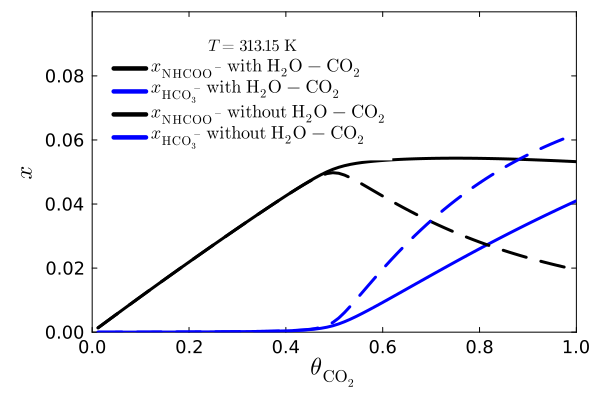

In [11]:
plt6 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T = 313.15 \ \mathrm{K}",
      xtickfont = font(12),
      ytickfont = font(12),
      xlims = (0, 1),
      ylims = (0, 0.1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      bottom_margin = 4mm,
      xguidefontsize=16,
      yguidefontsize=16)

plot!(plt6, loadfil, xNHCOO_313_assoc, 
      color = "black", 
      line = (:path, 3), 
      label = L"x_{\mathrm{NHCOO}^-} \mathrm{ with \ H_{2}O-CO_{2}}")

plot!(plt6, loadfil, xHCO3_313_assoc, 
      color = "blue", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-} \mathrm{ with \ H_{2}O-CO_{2}}")


 plot!(plt6, loadfil, xNHCOO_313_no_assoc, 
      color = "black", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{NHCOO}^-} \mathrm{ without \ H_{2}O-CO_{2}}")

plot!(plt6, loadfil, xHCO3_313_no_assoc, 
      color = "blue", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^-} \mathrm{ without \ H_{2}O-CO_{2}}")

xlabel!(plt6, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt6, L"x")

# savefig(plt4, "Compara_Loading_313")

# df = DataFrame(
#     CO2_Loading = loadfil,  
#     xNHCOO_with_assoc = xNHCOO_313_assoc, 
#     xNHCOO_without_assoc = xNHCOO_313_no_assoc, 
#     xHCO3_with_assoc = xHCO3_313_assoc, 
#     xHCO3_without_assoc = xHCO3_313_no_assoc, 
# )
# CSV.write("Speciation_313.csv", df)




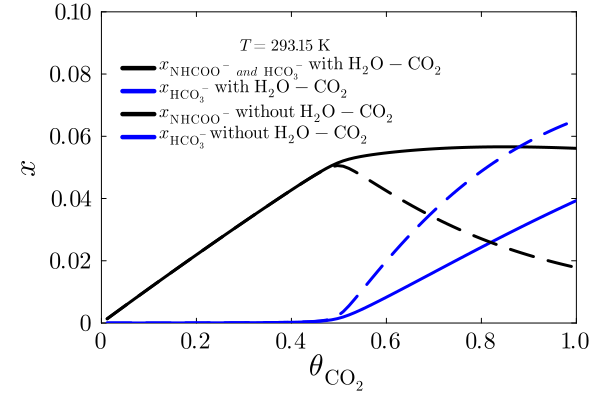

In [30]:
plt6 = plot(grid = :off, 
      framestyle = :box, 
      foreground_color_legend = nothing, 
      legend_font = font(12),
      legendtitle = L"T = 293.15 \ \mathrm{K}",
      legend_background_color = :transparent,
      xticks = ([0, 0.2, 0.4, 0.6, 0.8, 1.0],[L"0", L"0.2",L"0.4",L"0.6",L"0.8",L"1.0"]),
      xtickfont = font(16),
      yticks = ([0, 0.02, 0.04, 0.06, 0.08, 0.10],[L"0", L"0.02",L"0.04",L"0.06",L"0.08",L"0.10"]),
      ytickfont = font(16),
      xlims = (0, 1),
      ylims = (0, 0.1),
      legend =:topleft,
      left_margin = 4mm,
      right_margin = 4mm,
      bottom_margin = 4mm,
      xguidefontsize=20,
      yguidefontsize=20)

plot!(plt6, loadfil, xNHCOO_293_assoc, 
      color = "black", 
      line = (:path, 3), 
      label = L"x_{\mathrm{NHCOO}^- \ and \ \ \mathrm{HCO}_3^-} \mathrm{ with \ H_{2}O-CO_{2}}")

plot!(plt6, loadfil, xHCO3_293_assoc, 
      color = "blue", 
      line = (:path, 3), 
      label = L"x_{\mathrm{HCO}_3^-} \mathrm{ with \ H_{2}O-CO_{2}}")


 plot!(plt6, loadfil, xNHCOO_293_no_assoc, 
      color = "black", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{NHCOO}^-} \mathrm{ without \ H_{2}O-CO_{2}}")

plot!(plt6, loadfil, xHCO3_293_no_assoc, 
      color = "blue", 
      line = (:dash, 3), 
      label = L"x_{\mathrm{HCO}_3^{-}} \mathrm{ without \ H_{2}O-CO_{2}}")

xlabel!(plt6, L"\theta_{\mathrm{CO_2}}")
ylabel!(plt6, L"x")

#savefig(plt6, "C:\\Users\\fjm21\\OneDrive - Imperial College London\\Fourth Year\\Masters Project\\Figures\\Compara_Loading_293.png")

# df = DataFrame(
#     CO2_Loading = loadfil,  
#     xNHCOO_with_assoc = xNHCOO_293_assoc, 
#     xNHCOO_without_assoc = xNHCOO_293_no_assoc, 
#     xHCO3_with_assoc = xHCO3_293_assoc, 
#     xHCO3_without_assoc = xHCO3_293_no_assoc, 
# )
# CSV.write("Speciation_293.csv", df)